In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
def load_datasets(datasets):
  uploaded = files.upload()
  dataframes = {}
  for key, value in datasets.items():
    try:
      dataframes[key] = pd.read_csv(value, encoding='utf-8-sig')
    except FileNotFoundError:
      print(f"Error: File '{value}' not found. Skipping.")
  return dataframes

In [ ]:
def combine_dataframes(dataframes):
  combined_df = pd.DataFrame()
  for df in dataframes.values():
    df = df.drop(columns=['Unnamed: 0'])
    df['metric'] = df['metric'].replace({
    'f1 score': 'F1-Score',
    'balanced accuracy': 'Balanced Accuracy'
  })
    combined_df = pd.concat([combined_df, df], ignore_index=True)

    combined_df['scenario_id'] = (
        combined_df['scenario']
        .apply(lambda x: 1 if x == 'Scenario 1: standard' else 2)
    )

    combined_df['model'] = combined_df['dataset'].str.split('_').str[0]
    combined_df['model'] = combined_df['model'].str.rstrip('2').str.upper()
    combined_df['imputation'] = (
        combined_df['dataset'].str.endswith('_mf')
        .apply(lambda x: 'mf' if x else 'simple')
    )

  return combined_df

In [ ]:
def aggregate_performances_from_seeds(df, agg_cols, metric_cols, agg_functions):
  agg_df = df.groupby(agg_cols)[metric_cols].agg(agg_functions).reset_index()
  agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
  agg_df.columns = [col[:-1] if col.endswith('_') else col for col in agg_df.columns]
  return agg_df

In [ ]:
def plot_performance_decay_single_scenario(df, metric_name, x_colname, scenario_id):
    if scenario_id not in df['scenario_id'].unique():
        print(
            f"Warning: scenario_id must be 1 (standard) or 2 (drop intercorrelated)"
        )
        return

    if metric_name not in df['metric'].unique():
        print(
            f"Warning: metric_name must be 'F1-score' or 'Balanced Accuracy'"
        )
        return

    plot_df = df[df['scenario_id'] == scenario_id]
    plot_df = plot_df[plot_df['metric'] == metric_name]
    metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
    scenario_name = "Scenario Standard" if scenario_id == 1 else "Scenario Drop Intercorrelated"

    # Adjust figure size and add space at bottom for legend
    # plt.figure(figsize=(12, 4))
    plt.figure(figsize=(9, 3.5))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    models_list = np.sort(plot_df['model'].unique())

    # Create lines for the plot and legend handles
    lines = []
    i=0
    for model in models_list:
        for imputation in ['simple', 'mf']:
            model_df = plot_df[(plot_df['model'] == model) & (plot_df['imputation'] == imputation)]
            if imputation == "simple":
                line, = plt.plot(model_df[x_colname], model_df[metric_colname],
                               color=colors[i], linestyle='-')
            else:
                line, = plt.plot(model_df[x_colname], model_df[metric_colname],
                               color=colors[i], linestyle='--')
        lines.append(line)
        i = i+1

    plt.xlabel('Number of Disrupted Features', fontsize=10)
    plt.ylabel(metric_name, fontsize=10)
    plt.title(f'{scenario_name}: {metric_name} decline for different models')
    plt.xticks(range(0, 21))
    plt.xlim(0, 20)

    # Create custom legend handles for models
    legend_elements = [Line2D([0], [0], color=colors[i], label=model)
                      for i, model in enumerate(models_list)]

    # Add custom legend handles for imputation types
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='-', label='Simple Imputation'),
        Line2D([0], [0], color='gray', linestyle='--', label='MissForest Imputation')
    ])

    # Create legend at the bottom
    plt.legend(handles=legend_elements,
              bbox_to_anchor=(0.5, -0.2),
              loc='upper center',
              borderaxespad=0.,
              fontsize=10,
              ncol=len(models_list) + 2)

    plt.grid(True)
    # Adjust layout to make room for legend at bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Add space at bottom for legend
    plt.show()


In [ ]:
def compare_scenarios(df, metric_name):
    models_list = np.sort(df['model'].unique())
    df = df[df['metric'] == metric_name]
    scenario1_df = df[df['scenario_id'] == 1]
    scenario2_df = df[df['scenario_id'] == 2]
    metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
    scenario_labels = ["Scenario Standard", "Scenario Drop Intercorrelated"]

    # Create subplots in a 2x4 grid
    fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True)
    axes = axes.flatten()

    colors = ['#1f77b4', '#ff7f0e']
    lines = []
    labels = []

    for ax_index, model in enumerate(models_list):
        model_scenario1 = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'simple')]
        model_scenario2 = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'simple')]
        model_scenario1_mf = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'mf')]
        model_scenario2_mf = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'mf')]

        # Store lines and labels only from the first subplot
        if ax_index == 0:
            line1, = axes[ax_index].plot(model_scenario1['num_feat_missing'], model_scenario1[metric_colname],
                                       label=f"{scenario_labels[0]} (Simple)", color=colors[0])
            line2, = axes[ax_index].plot(model_scenario2['num_feat_missing'], model_scenario2[metric_colname],
                                       label=f"{scenario_labels[1]} (Simple)", color=colors[1])
            line3, = axes[ax_index].plot(model_scenario1_mf['num_feat_missing'], model_scenario1_mf[metric_colname],
                                       label=f"{scenario_labels[0]} (MissForest)", color=colors[0], linestyle='--')
            line4, = axes[ax_index].plot(model_scenario2_mf['num_feat_missing'], model_scenario2_mf[metric_colname],
                                       label=f"{scenario_labels[1]} (MissForest)", color=colors[1], linestyle='--')
            lines = [line1, line2, line3, line4]
        else:
            axes[ax_index].plot(model_scenario1['num_feat_missing'], model_scenario1[metric_colname],
                              color=colors[0])
            axes[ax_index].plot(model_scenario2['num_feat_missing'], model_scenario2[metric_colname],
                              color=colors[1])
            axes[ax_index].plot(model_scenario1_mf['num_feat_missing'], model_scenario1_mf[metric_colname],
                              color=colors[0], linestyle='--')
            axes[ax_index].plot(model_scenario2_mf['num_feat_missing'], model_scenario2_mf[metric_colname],
                              color=colors[1], linestyle='--')

        axes[ax_index].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        axes[ax_index].set_xlim(0, 20)
        axes[ax_index].set_xlabel('Number of features disrupted')
        axes[ax_index].set_ylabel(metric_name)
        axes[ax_index].set_title(f'{model}')

    # Hide unused subplots
    for i in range(len(models_list), len(axes)):
        axes[i].axis('off')

    # Add single legend at the bottom
    fig.legend(lines, [line.get_label() for line in lines],
              loc='center', bbox_to_anchor=(0.5, 0.02),
              ncol=4)

    plt.subplots_adjust(hspace=0.4, bottom=0.14)  # Adjusted bottom margin for legend
    plt.show()

In [ ]:
def plot_performance_after_x_features_imputed(df, scenario_id, metric_name, num_feat_imputed_list):
  if metric_name not in df['metric'].unique():
    print(
        f"Warning: metric_name must be 'F1-Score' or 'Balanced Accuracy'"
    )
    return

  if scenario_id not in df['scenario_id'].unique():
    print(
        f"Warning: scenario_id must be 1 (standard) or 2 (drop intercorrelated)"
    )
    return

  scenario_name = "Scenario Standard" if scenario_id == 1 else "Scenario Drop Intercorrelated"
  metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
  df = df[(df['metric'] == metric_name) & (df['scenario_id'] == scenario_id)]
  df_0_imputed = df[df['num_feat_missing'] == 0]

  num_plots = len(num_feat_imputed_list)
  fig, axes = plt.subplots(
      1, num_plots, figsize=(8 * num_plots, 6), sharey=True
  )

  # Check if axes is a single Axes object or an array
  if num_plots == 1:
    axes = [axes]

  # Create scatterplot for the first subplot to get legend handles and labels
  df_x_imputed = df[df['num_feat_missing'] == num_feat_imputed_list[0]]
  merged_df = pd.merge(df_0_imputed[['model', 'imputation', metric_colname]],
                      df_x_imputed[['model', 'imputation', metric_colname]],
                      on=['model', 'imputation'],
                      suffixes=('_base', f'_{num_feat_imputed_list[0]}_imputed'))

  scatter = sns.scatterplot(ax=axes[0], data=merged_df,
                            x=f'{metric_colname}_{num_feat_imputed_list[0]}_imputed',
                            y=f'{metric_colname}_base', hue='model', s=100,
                            style='imputation')

  # Get legend handles and labels
  handles, labels = scatter.get_legend_handles_labels()

  # Remove legend from the first subplot
  axes[0].get_legend().remove()

  # Create remaining scatterplots without legends
  for i, num_feat_imputed in enumerate(num_feat_imputed_list):
    df_x_imputed = df[df['num_feat_missing'] == num_feat_imputed]
    merged_df = pd.merge(df_0_imputed[['model', 'imputation', metric_colname]],
                        df_x_imputed[['model', 'imputation', metric_colname]],
                        on=['model', 'imputation'],
                        suffixes=('_base', f'_{num_feat_imputed}_imputed'))

    sns.scatterplot(ax=axes[i], data=merged_df,
                    x=f'{metric_colname}_{num_feat_imputed}_imputed',
                    y=f'{metric_colname}_base', hue='model',
                    style='imputation', legend=False, s=150) # legend=False to avoid creating multiple legends

    axes[i].set_xlabel(f'{metric_name} with {num_feat_imputed} disrupted features', fontsize=20)
    axes[i].set_ylabel(f'{metric_name} base', fontsize=20)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].set_title(f'{scenario_name}: {metric_name} base vs {num_feat_imputed} disrupted features', fontsize=14)
    axes[i].grid(True)

  # Create a single legend outside the subplots
  fig.legend(handles, labels, title="Model & Imputation", loc='lower center',
             bbox_to_anchor=(0.5, -0.2), ncol=12, fontsize=20)

  plt.tight_layout()
  plt.show()

In [ ]:
german_datasets = {
    'german_scenario1_seed_1981': 'german_credit_scenario1_seed_1981.csv',
    'german_scenario1_seed_2024': 'german_credit_scenario1_seed_2024.csv',
    'german_scenario1_seed_2025': 'german_credit_scenario1_seed_2025.csv'
}

taiwanese_datasets = {
    'taiwan_scenario1_seed_1981': 'taiwanese_bankruptcy_scenario1_seed_1981.csv',
    'taiwan_scenario1_seed_2024': 'taiwanese_bankruptcy_scenario1_seed_2024.csv',
    'taiwan_scenario1_seed_2025': 'taiwanese_bankruptcy_scenario1_seed_2025.csv',
    'taiwan_scenario2_seed_1981': 'taiwanese_bankruptcy_scenario2_seed_1981.csv',
    'taiwan_scenario2_seed_2024': 'taiwanese_bankruptcy_scenario2_seed_2024.csv',
    'taiwan_scenario2_seed_2025': 'taiwanese_bankruptcy_scenario2_seed_2025.csv',
}

default_cc_datasets = {
    'default_cc_scenario1_seed_1981': 'default_cc_scenario1_seed_1981.csv',
    'default_cc_scenario1_seed_2024': 'default_cc_scenario1_seed_2024.csv',
    'default_cc_scenario1_seed_2025': 'default_cc_scenario1_seed_2025.csv',
    'default_cc_scenario2_seed_1981': 'default_cc_scenario2_seed_1981.csv',
    'default_cc_scenario2_seed_2024': 'default_cc_scenario2_seed_2024.csv',
    'default_cc_scenario2_seed_2025': 'default_cc_scenario2_seed_2025.csv'
}

default_cc_temp_datasets = {
    'default_cc_temp_scenario1_seed_1981': 'default_cc_temp_scenario1_seed_1981.csv',
    'default_cc_temp_scenario1_seed_2024': 'default_cc_temp_scenario1_seed_2024.csv',
    'default_cc_temp_scenario1_seed_2025': 'default_cc_temp_scenario1_seed_2025.csv',
    'default_cc_temp_scenario2_seed_1981': 'default_cc_temp_scenario2_seed_1981.csv',
    'default_cc_temp_scenario2_seed_2024': 'default_cc_temp_scenario2_seed_2024.csv',
    'default_cc_temp_scenario2_seed_2025': 'default_cc_temp_scenario2_seed_2025.csv'
}

dataframes = load_datasets(taiwanese_datasets)

Saving taiwanese_bankruptcy_scenario1_seed_1981.csv to taiwanese_bankruptcy_scenario1_seed_1981.csv
Saving taiwanese_bankruptcy_scenario1_seed_2024.csv to taiwanese_bankruptcy_scenario1_seed_2024.csv
Saving taiwanese_bankruptcy_scenario1_seed_2025.csv to taiwanese_bankruptcy_scenario1_seed_2025.csv
Saving taiwanese_bankruptcy_scenario2_seed_1981.csv to taiwanese_bankruptcy_scenario2_seed_1981.csv
Saving taiwanese_bankruptcy_scenario2_seed_2024.csv to taiwanese_bankruptcy_scenario2_seed_2024.csv
Saving taiwanese_bankruptcy_scenario2_seed_2025.csv to taiwanese_bankruptcy_scenario2_seed_2025.csv


In [ ]:
dataframes['taiwan_scenario1_seed_1981']

,Unnamed: 0,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric
0,0,36,1165,155,8,18.85,81.82,88.26,88.05,30.64,85.04,0,NaN,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,f1 score
1,1,33,1173,147,11,18.33,75.00,88.86,88.42,29.46,81.93,1,['Equity to Liability'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,f1 score
2,2,31,1186,134,13,18.79,70.45,89.85,89.22,29.67,80.15,2,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,f1 score
3,3,33,1176,144,11,18.64,75.00,89.09,88.64,29.86,82.05,3,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,f1 score
4,4,36,1169,151,8,19.25,81.82,88.56,88.34,31.17,85.19,4,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,f1 score
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,583,33,1195,125,11,20.89,75.00,90.53,90.03,32.67,82.77,16,"['Net worth/Assets', 'Debt ratio %', 'Operatin...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,1981,balanced accuracy
584,584,33,1196,124,11,21.02,75.00,90.61,90.10,32.84,82.80,17,"['Net worth/Assets', 'Debt ratio %', 'Operatin...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,1981,balanced accuracy
585,585,33,1198,122,11,21.29,75.00,90.76,90.25,33.17,82.88,18,"['Net worth/Assets', 'Debt ratio %', 'Operatin...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,1981,balanced accuracy
586,586,33,1198,122,11,21.29,75.00,90.76,90.25,33.17,82.88,19,"['Net worth/Assets', 'Debt ratio %', 'Operatin...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,1981,balanced accuracy


In [ ]:
combined_df = combine_dataframes(dataframes)
combined_df

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
0,36,1165,155,8,18.85,81.82,88.26,88.05,30.64,85.04,0,NaN,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
1,33,1173,147,11,18.33,75.00,88.86,88.42,29.46,81.93,1,['Equity to Liability'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
2,31,1186,134,13,18.79,70.45,89.85,89.22,29.67,80.15,2,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
3,33,1176,144,11,18.64,75.00,89.09,88.64,29.86,82.05,3,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
4,36,1169,151,8,19.25,81.82,88.56,88.34,31.17,85.19,4,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,30,1221,99,14,23.26,68.18,92.50,91.72,34.68,80.34,16,"['Tax rate (A)', 'Interest Coverage Ratio (Int...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3524,27,1232,88,17,23.48,61.36,93.33,92.30,33.96,77.35,17,"['Tax rate (A)', 'Interest Coverage Ratio (Int...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3525,26,1238,82,18,24.07,59.09,93.79,92.67,34.21,76.44,18,"['Tax rate (A)', 'Interest Coverage Ratio (Int...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3526,26,1237,83,18,23.85,59.09,93.71,92.60,33.99,76.40,19,"['Tax rate (A)', 'Interest Coverage Ratio (Int...",et2_perf_mf,Taiwanese Bankruptcy,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf


In [ ]:
agg_cols = ['source', 'model', 'imputation', 'scenario_id', 'scenario', 'metric', 'num_feat_missing']
metric_cols = ['f1_score', 'balanced_accuracy']
agg_functions = ['mean', 'std']
agg_df = aggregate_performances_from_seeds(combined_df, agg_cols, metric_cols, agg_functions)
agg_df

,source,model,imputation,scenario_id,scenario,metric,num_feat_missing,f1_score_mean,f1_score_std,balanced_accuracy_mean,balanced_accuracy_std
0,Taiwanese Bankruptcy,DT,mf,1,Scenario 1: standard,Balanced Accuracy,0,27.520000,1.009554,84.900000,3.687045
1,Taiwanese Bankruptcy,DT,mf,1,Scenario 1: standard,Balanced Accuracy,1,26.413333,1.899588,84.180000,3.407228
2,Taiwanese Bankruptcy,DT,mf,1,Scenario 1: standard,Balanced Accuracy,2,25.796667,1.748180,83.623333,2.761708
3,Taiwanese Bankruptcy,DT,mf,1,Scenario 1: standard,Balanced Accuracy,3,25.580000,1.705638,82.640000,1.285729
4,Taiwanese Bankruptcy,DT,mf,1,Scenario 1: standard,Balanced Accuracy,4,25.763333,2.754893,83.243333,2.692979
...,...,...,...,...,...,...,...,...,...,...,...
1171,Taiwanese Bankruptcy,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,16,0.000000,0.000000,49.973333,0.046188
1172,Taiwanese Bankruptcy,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,17,0.000000,0.000000,49.986667,0.023094
1173,Taiwanese Bankruptcy,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,18,0.000000,0.000000,50.000000,0.000000
1174,Taiwanese Bankruptcy,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,19,0.000000,0.000000,50.000000,0.000000


# **Metrics evolution**

## **F1 score**

*Sanity check of values*

In [ ]:
combined_df.head()

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
0,36,1165,155,8,18.85,81.82,88.26,88.05,30.64,85.04,0,NaN,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
1,33,1173,147,11,18.33,75.00,88.86,88.42,29.46,81.93,1,['Equity to Liability'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
2,31,1186,134,13,18.79,70.45,89.85,89.22,29.67,80.15,2,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
3,33,1176,144,11,18.64,75.00,89.09,88.64,29.86,82.05,3,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
4,36,1169,151,8,19.25,81.82,88.56,88.34,31.17,85.19,4,"['Equity to Liability', 'Cash Flow to Liabilit...",lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple


In [ ]:
combined_df['model'].unique()

array(['LR', 'SVM', 'DT', 'RF', 'GBT', 'XGB', 'ET'], dtype=object)

In [ ]:
cond1 = (combined_df['model'] == 'LR')
cond2 = (combined_df['scenario_id'] == 1)
cond3 = (combined_df['metric'] == 'F1-Score')
cond4 = (combined_df['num_feat_missing'] == 1)
combined_df[cond1 & cond2 & cond3 & cond4]

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
1,33,1173,147,11,18.33,75.00,88.86,88.42,29.46,81.93,1,['Equity to Liability'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,simple
148,36,1184,136,8,20.93,81.82,89.70,89.44,33.33,85.76,1,['Equity to Liability'] imputed,lr_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,1981,F1-Score,1,LR,mf
589,38,1077,243,6,13.52,86.36,81.59,81.74,23.38,83.98,1,['Quick Assets/Total Assets'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,2024,F1-Score,1,LR,simple
736,38,1094,226,6,14.39,86.36,82.88,82.99,24.68,84.62,1,['Quick Assets/Total Assets'] imputed,lr_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,2024,F1-Score,1,LR,mf
1177,33,1149,171,11,16.18,75.00,87.05,86.66,26.61,81.02,1,['Equity to Liability'] imputed,lr_perf,Taiwanese Bankruptcy,Scenario 1: standard,2025,F1-Score,1,LR,simple
1324,36,1161,159,8,18.46,81.82,87.95,87.76,30.13,84.89,1,['Equity to Liability'] imputed,lr_perf_mf,Taiwanese Bankruptcy,Scenario 1: standard,2025,F1-Score,1,LR,mf


In [ ]:
agg_df[(agg_df['scenario_id'] == 1) & (agg_df['metric'] == 'F1-Score') & (agg_df['num_feat_missing'] == 1) & (agg_df['model'] == 'LR')]

,source,model,imputation,scenario_id,scenario,metric,num_feat_missing,f1_score_mean,f1_score_std,balanced_accuracy_mean,balanced_accuracy_std
526,Taiwanese Bankruptcy,LR,mf,1,Scenario 1: standard,F1-Score,1,29.380000,4.373500,85.09,0.595735
610,Taiwanese Bankruptcy,LR,simple,1,Scenario 1: standard,F1-Score,1,26.483333,3.041979,82.31,1.516146


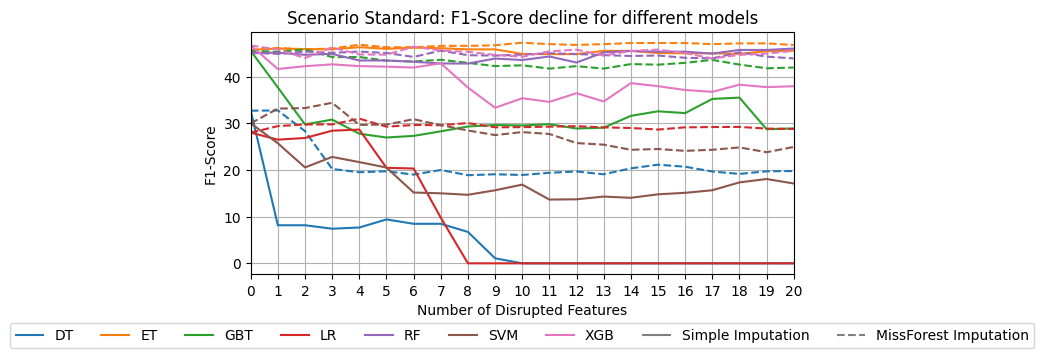

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'F1-Score', 'num_feat_missing', 1)

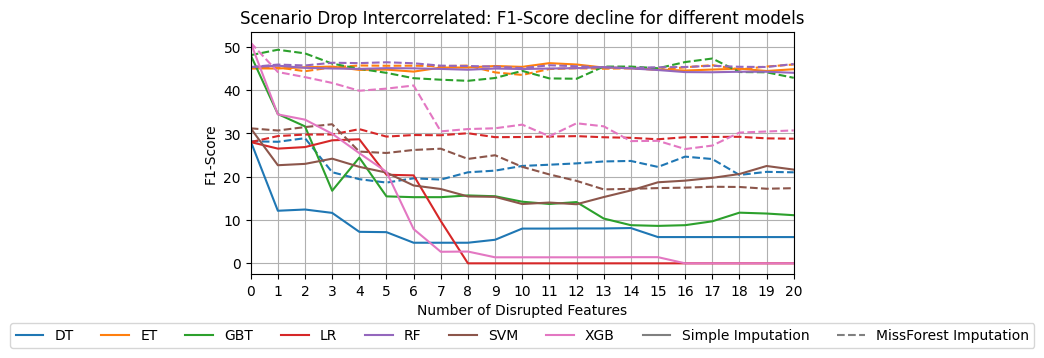

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'F1-Score', 'num_feat_missing', 2)

## **Balanced accuracy**

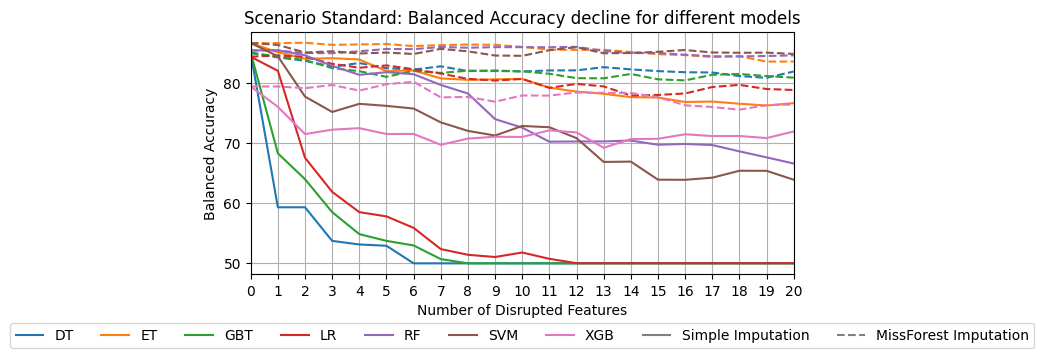

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'Balanced Accuracy', 'num_feat_missing', 1)

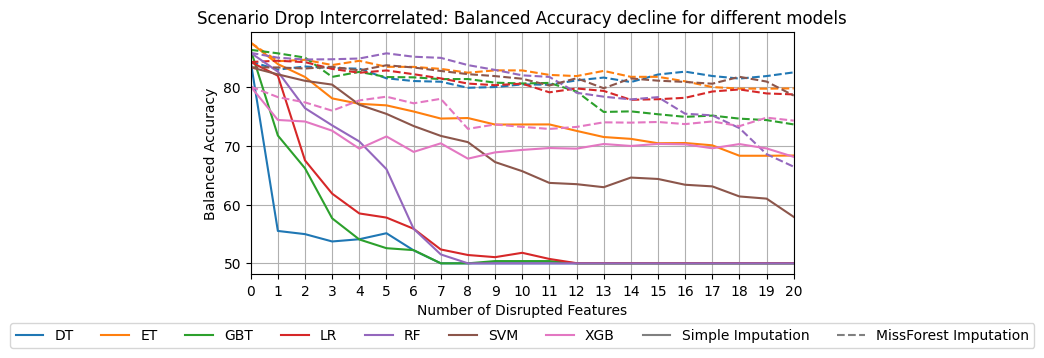

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'Balanced Accuracy', 'num_feat_missing', 2)

# **Base performance vs Performance after disruption of x features**
Models on the top right of the plot are prefferable due to have initial high performance and maintain a high performance after disruption of several features

## **F1 score**

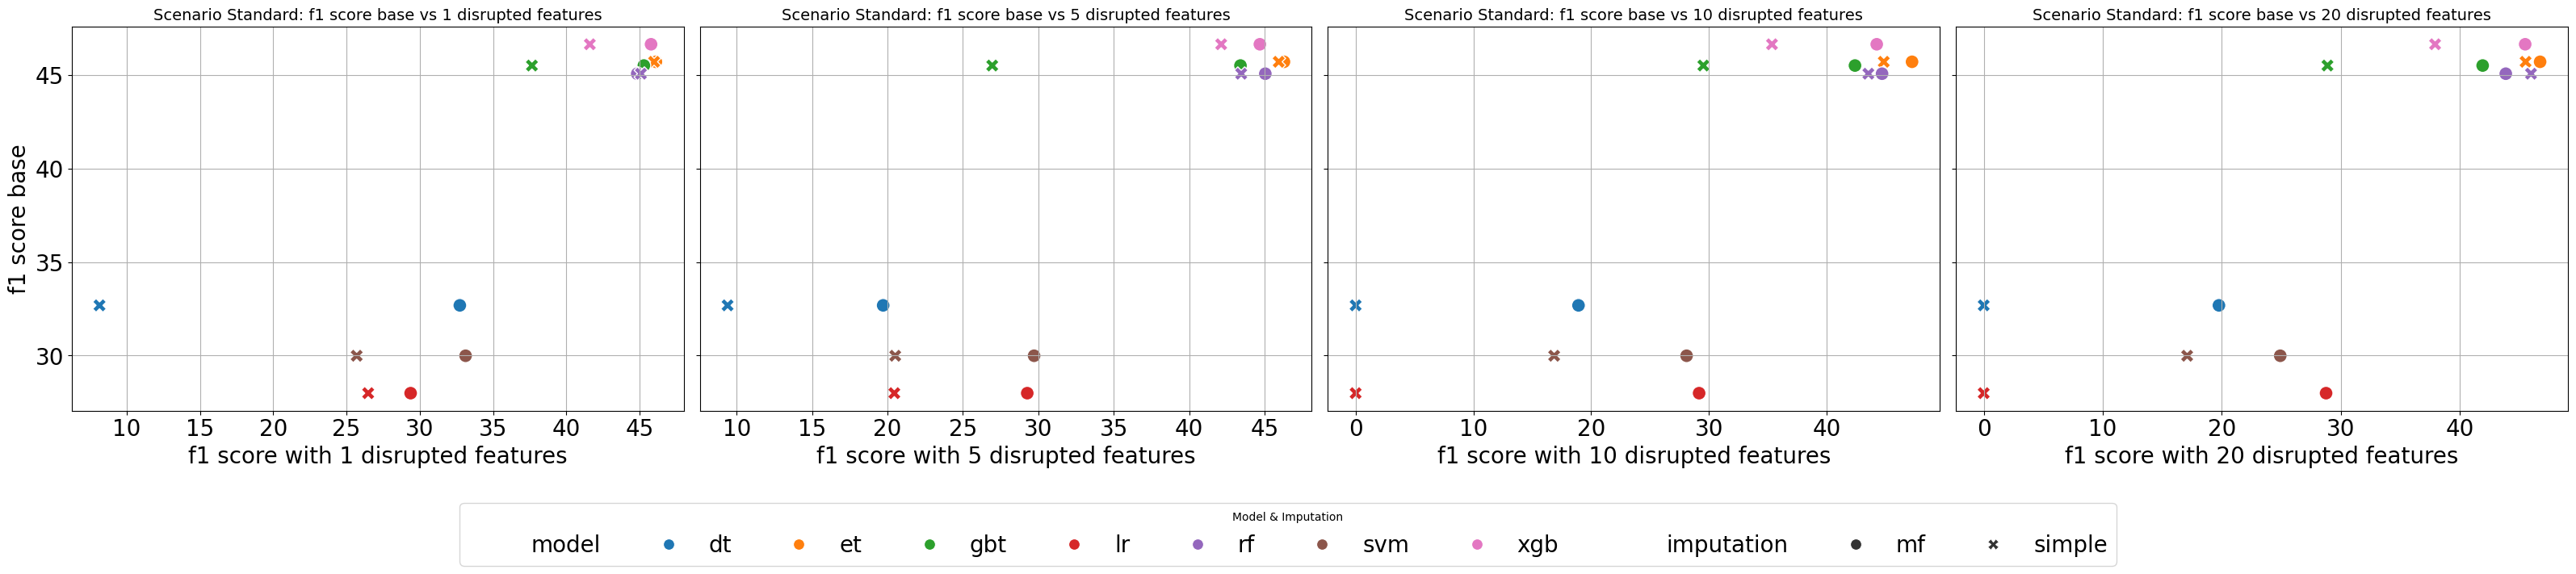

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 1, 'F1-Score', [1, 5, 10, 20])

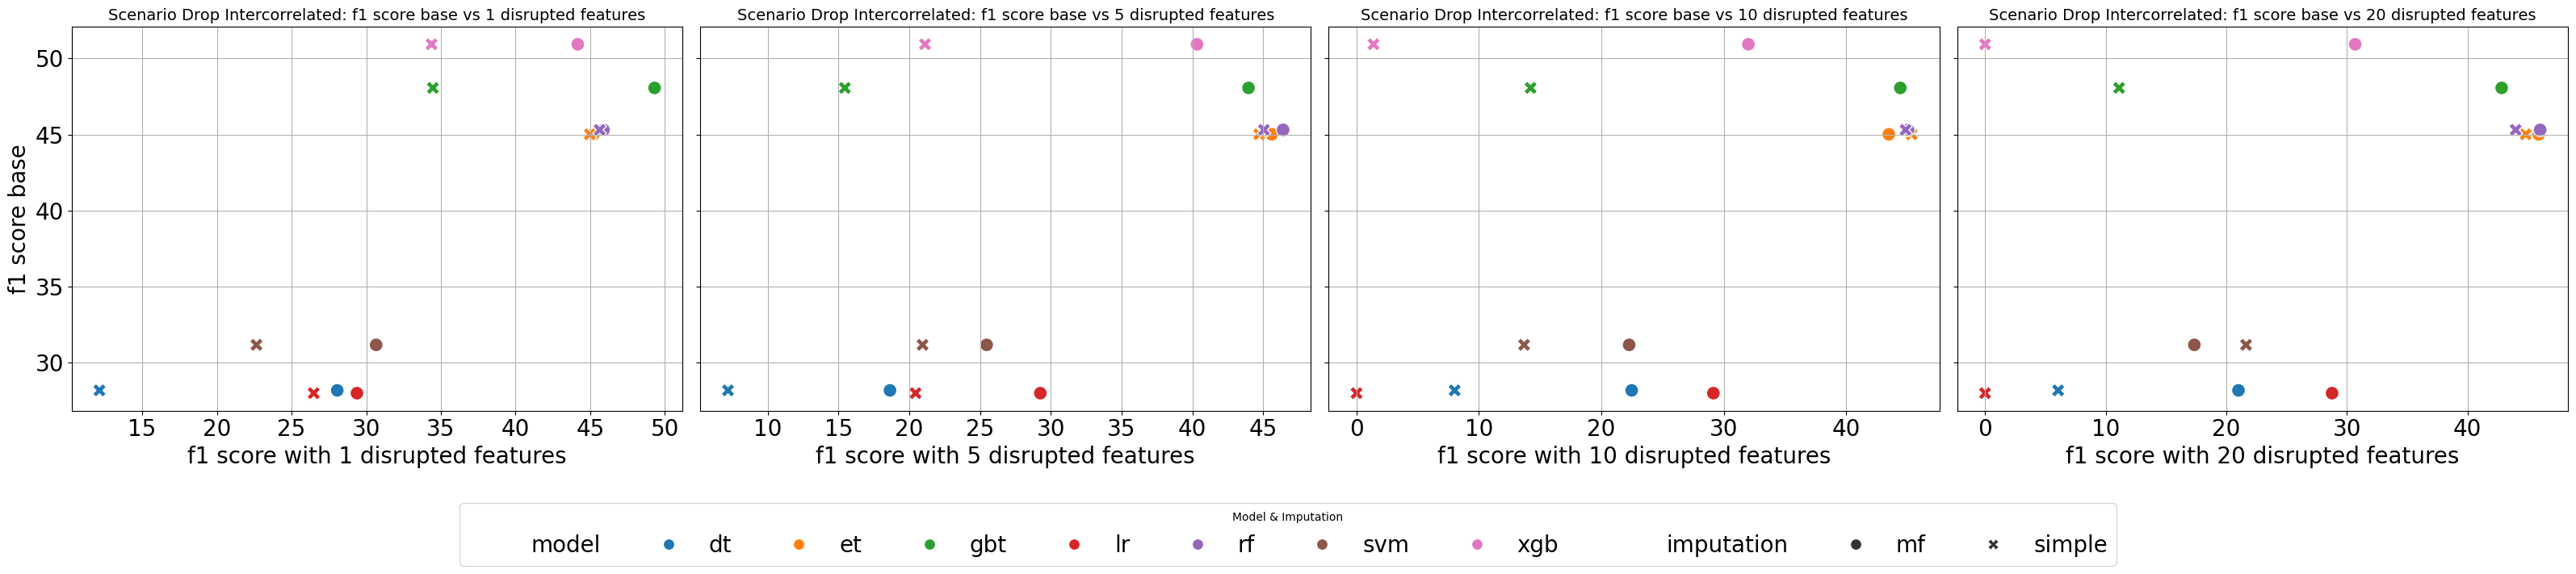

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 2, 'F1-Score', [1, 5, 10, 20])

## **Balanced accuracy**

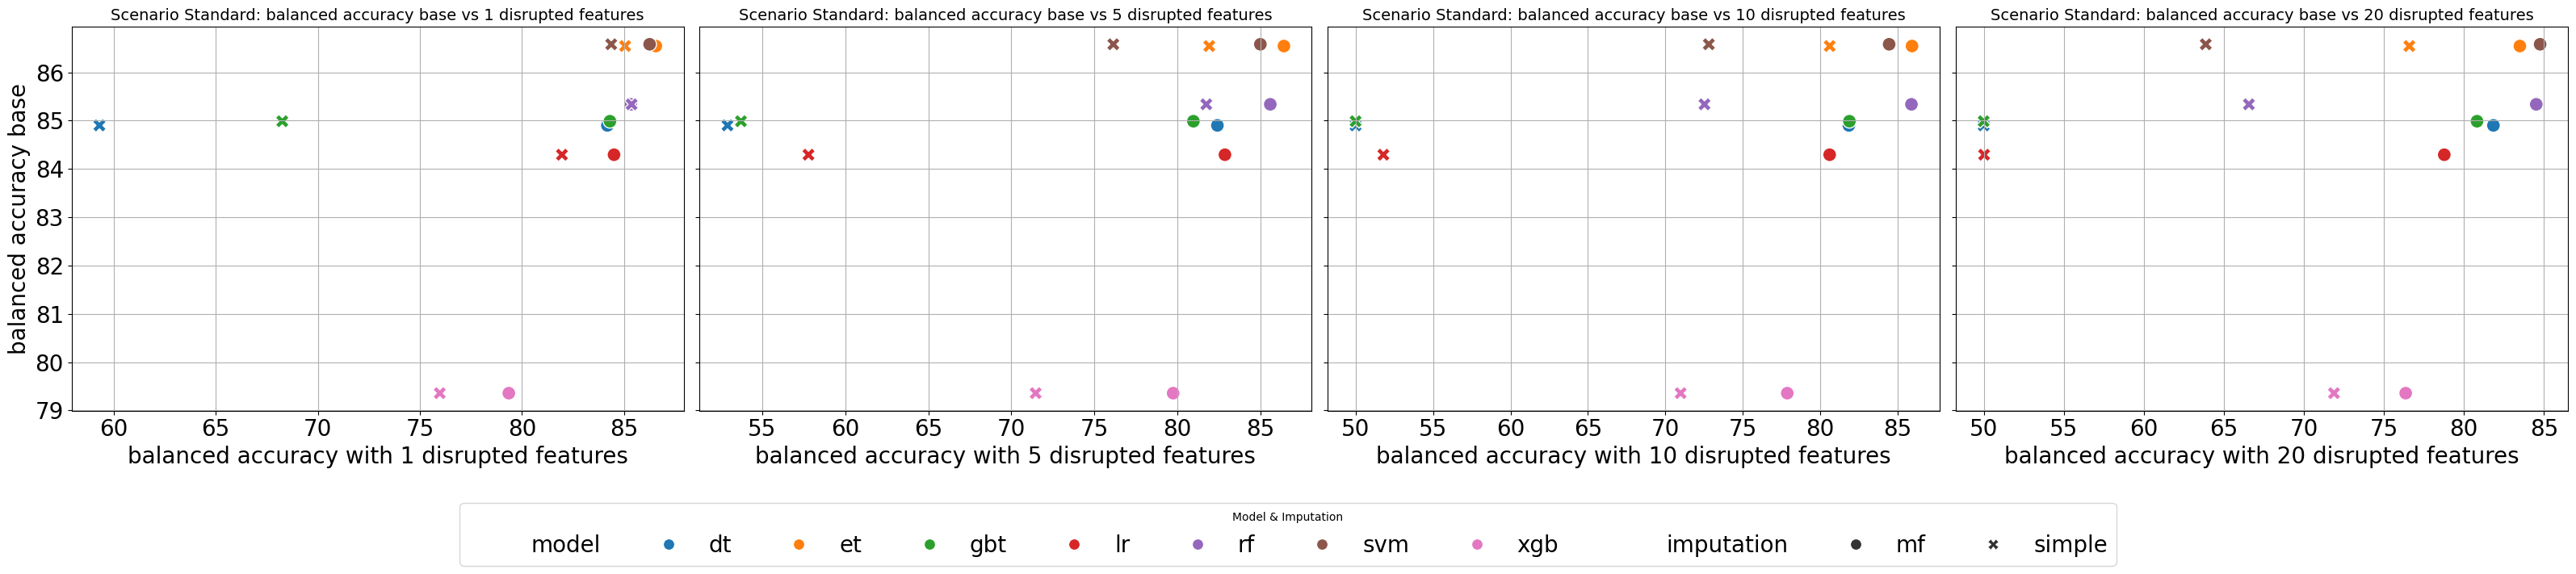

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 1, 'Balanced Accuracy', [1, 5, 10, 20])

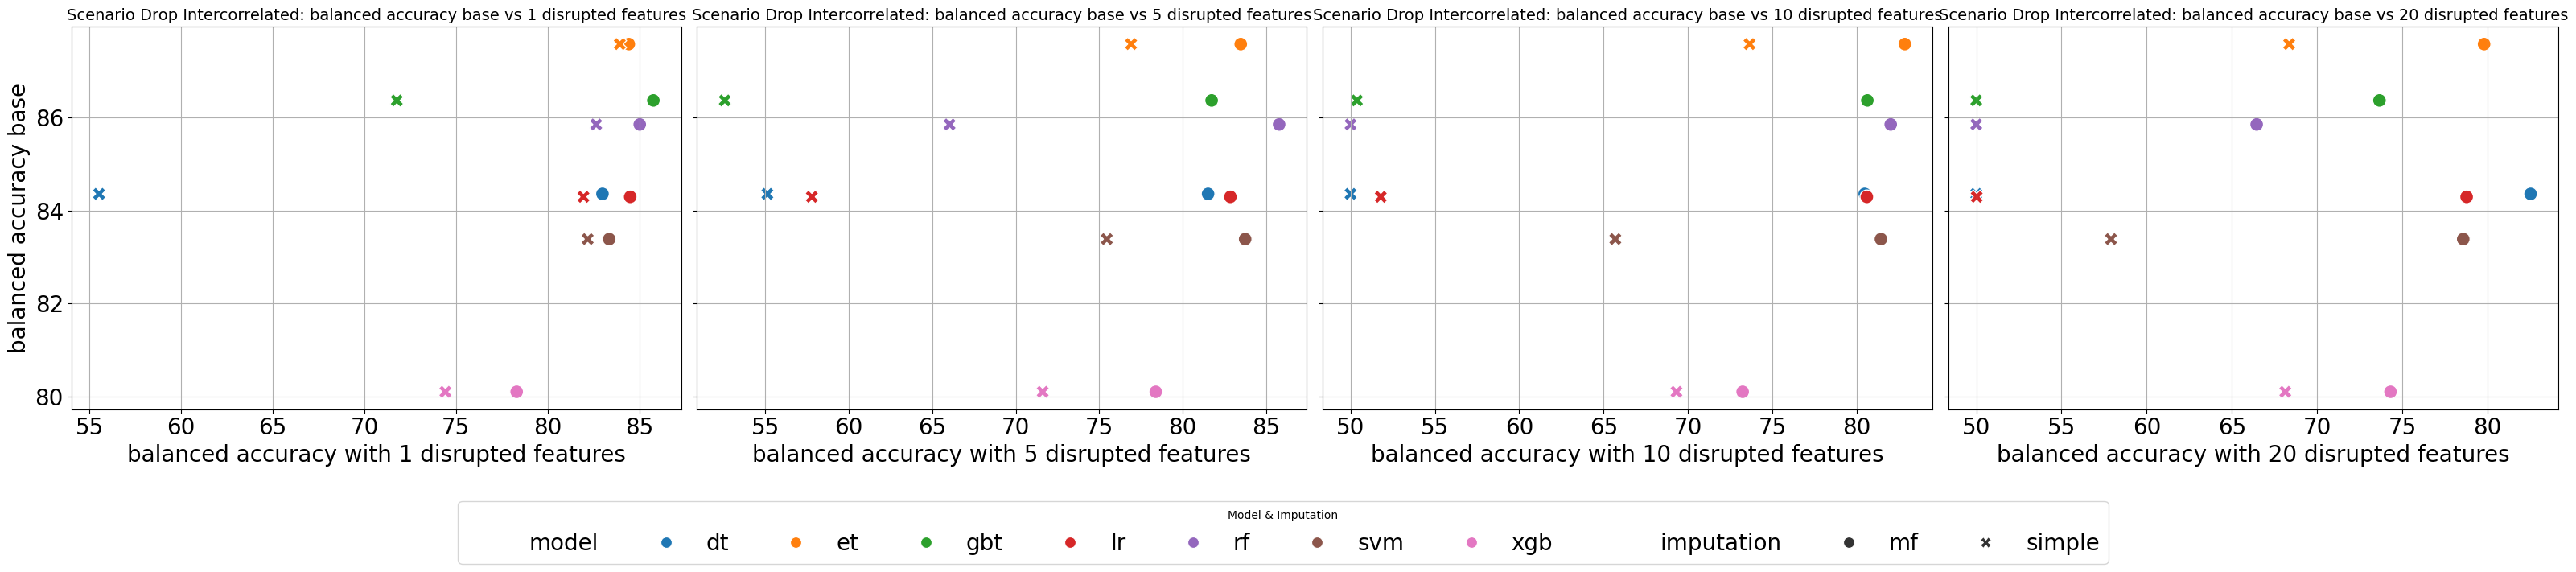

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 2, 'Balanced Accuracy', [1, 5, 10, 20])

# **Comparison of scenarios**

## **F1 score**

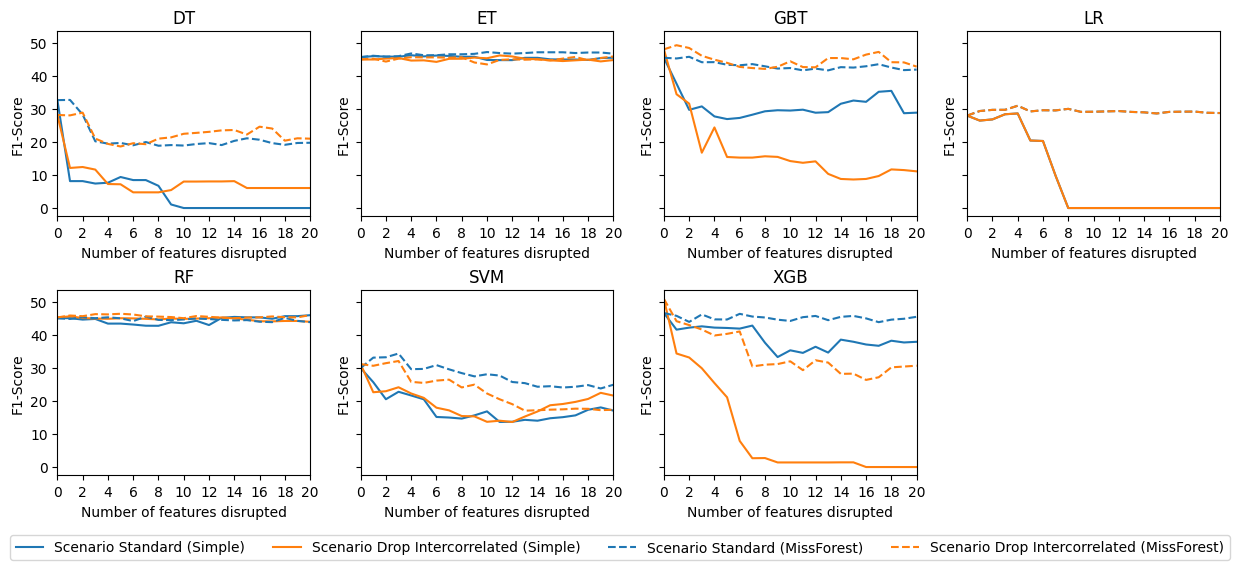

In [ ]:
compare_scenarios(agg_df, 'F1-Score')

## **Balanced accuracy**

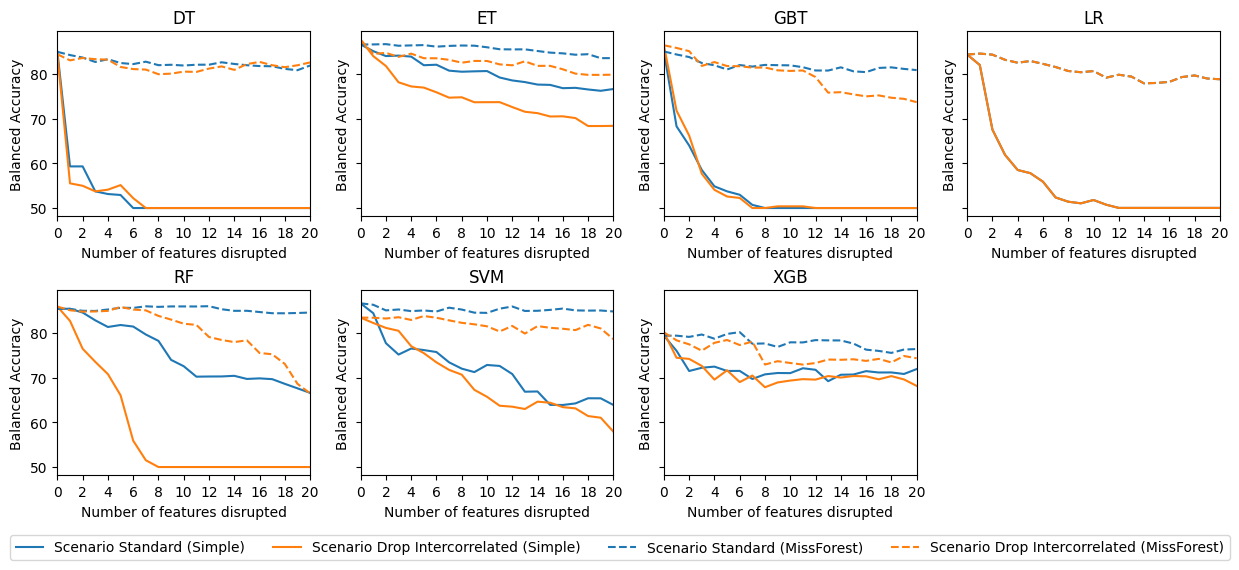

In [ ]:
compare_scenarios(agg_df, 'Balanced Accuracy')